In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
import ipywidgets as widgets

In [2]:
def exponential(value, gamma):
    return np.exp( - gamma * value)

def build_covariance_matrix(variance, function, width=3):
    n = variance.shape[0]
    var = np.diag(variance.flatten())
    
    distance_map = [
        np.eye(n*n)
    ]
    
    if width > 1:
        # connect each row
        tpRow = np.zeros((n,1), dtype=np.float32)
        tpRow[1] = 1
        offdi = la.toeplitz(tpRow)
        # connect each column
        tpEdge = np.zeros((n,1), dtype=np.float32)
        tpEdge[0] = 1
        offedge = la.toeplitz(tpEdge)
        #connect diagonals
        tpDiag = np.zeros((n,1), dtype=np.float32)
        tpDiag[1] = 1
        offdiag = la.toeplitz(tpDiag)

        I = np.eye(n, dtype=np.float32)
        Ileft = np.roll(I, 1, axis=0) + np.roll(I, -1, axis=0)
        Ileft[0,-1] = 0
        Ileft[-1,0] = 0

        A = np.kron(I, offdi) + np.kron(Ileft, offedge)  + np.kron(Ileft, offdiag)
        A *= function(1, 1/np.log(width))
        
        distance_map.append(A)
        
    for weight in range(2, width):
        A_depth = distance_map[-1] @ distance_map[1]
        A_depth[ A_depth > 0 ] = 1.0
        for A_prev in distance_map:
            A_depth[ A_prev > 0 ] = 0.0
        
        A_depth *= function(weight, 1/np.log(width))
            
        distance_map.append(A_depth)

        
    # enforce positive semi-definite
    R = np.sum(distance_map, axis=0)
    #R = R @ R.T
    #R /= R.max()
    # sigma_x * rho * sigma_y
    covariance = var @ R @ var.T
    
    return covariance

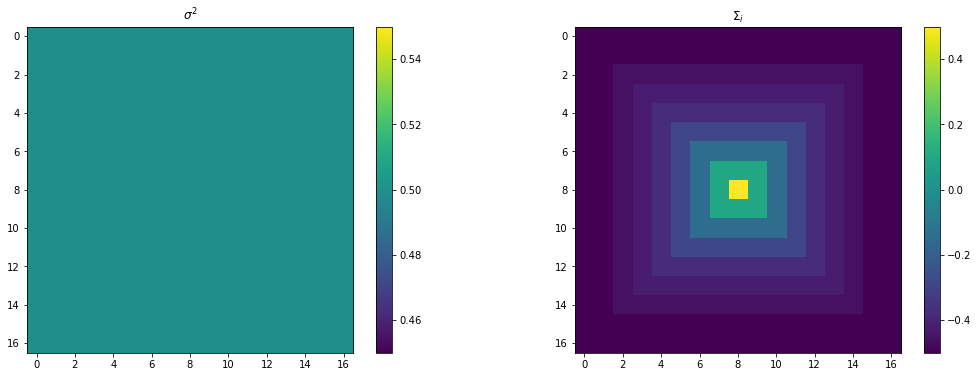

In [3]:
gridDimensions = np.array([17,17])
variance = np.ones(gridDimensions)

Sigma = build_covariance_matrix(variance, exponential, 7) - 0.5

# center pixel
targetPixel = 17//2 * 17 + 17//2
Sigma_i = Sigma[targetPixel,:].reshape(gridDimensions)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(np.diag(Sigma).reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.show()

## Pearson distance
\begin{align}
    d_{X,Y} &= 1 - \rho_{X,Y}, & d_{X,Y} &\in [0,2] \\
    \rho_{X,Y} &= \frac{\Sigma_{X,Y}}{\sigma_X \sigma_Y}
\end{align}

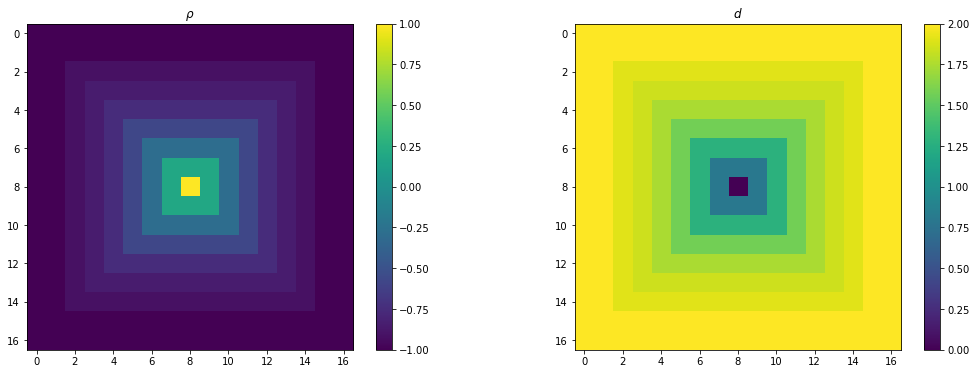

In [4]:
# compute the pearson coefficient
variances = np.sqrt(np.diag(Sigma))
sigma_x = variances[targetPixel]
# get only the correlated variances
covariances = Sigma_i.flatten()
rho = np.array([covariances[idx] / (sigma_x * sigma_y) for idx,sigma_y in enumerate(variances)]).reshape(gridDimensions)

d = 1 - rho

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(rho, vmin=-1, vmax=1)
plt.title(r'$\rho$')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(d, vmin=0, vmax=2)
plt.title('$d$')
plt.colorbar()
plt.show()

# Identify the closest pixels with the target pearson factor
$$
    d(\rho) = 2 - \vert 1 - \rho - d_{X,Y} \vert
$$

In [5]:
@widgets.interact(min_rho=(-1,1,0.1))
def show_rho(min_rho=-0.5):
    locality = 2 - np.abs(1 - min_rho - d)

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.imshow(d)
    plt.title(r'$d$')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(locality, vmin=0, vmax=2)
    plt.title(r'$d(0.5)$')
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=-0.5, description='min_rho', max=1.0, min=-1.0), Output()), _dom_class…

# Experiment

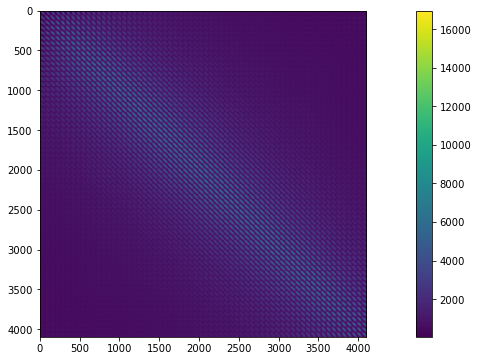

In [6]:
Sigma = np.load('../../Data/iradon/Sigma_w10_p5_shepp-logan.npy')

plt.figure(figsize=(18,6))
plt.imshow(Sigma)
plt.colorbar()
plt.show()

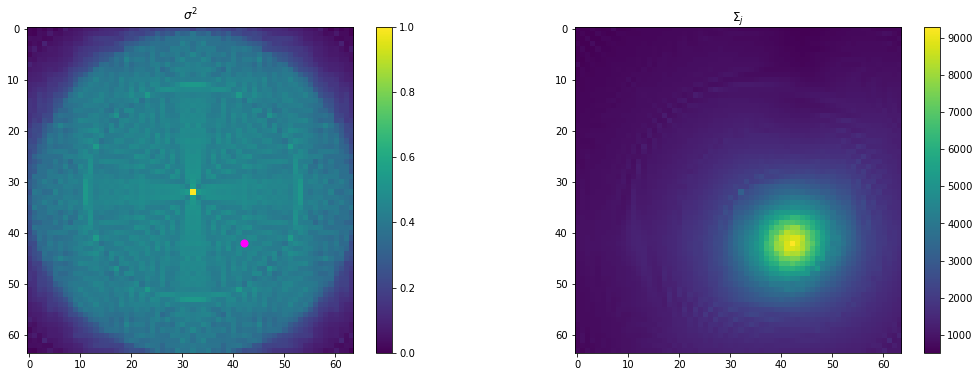

In [7]:
gridDimensions = np.array([64,64])
y = gridDimensions[0]//3*2
x = gridDimensions[1]//3*2
j = gridDimensions[1]*y + x
Sigma_j = Sigma[j,:].reshape(gridDimensions)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(np.diag(Sigma).reshape(gridDimensions))
plt.scatter(x,y, s=50, c='magenta')
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Sigma_j)
plt.title(r'$\Sigma_j$')
plt.colorbar()
plt.show()

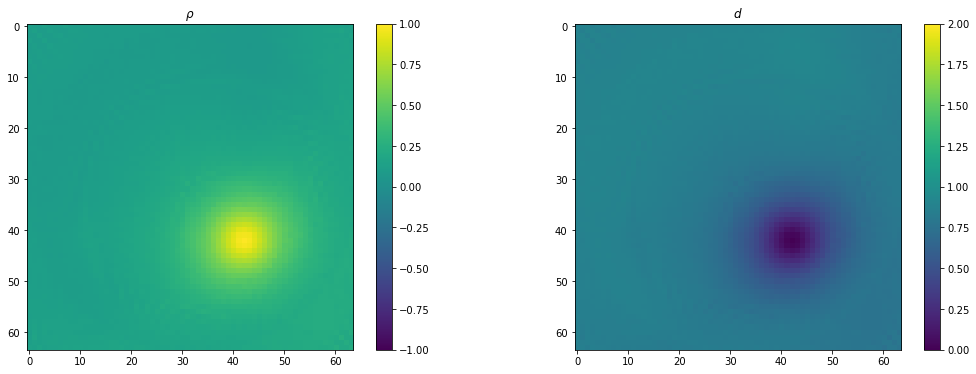

In [8]:
# compute the pearson coefficient
variances = np.sqrt(np.diag(Sigma))
sigma_x = variances[j]
# get only the correlated variances
covariances = Sigma_j.flatten()
rho_j = np.array([covariances[idx] / (sigma_x * sigma_y) for idx,sigma_y in enumerate(variances)]).reshape(gridDimensions)

d = 1 - rho_j

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(rho_j, vmin=-1, vmax=1)
plt.title(r'$\rho$')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(d, vmin=0, vmax=2)
plt.title('$d$')
plt.colorbar()
plt.show()

In [9]:
@widgets.interact(target_rho=(-1,1,0.1))
def show_locality(target_rho=0.75):
    locality = 2 - np.abs(1 - target_rho - d)

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.imshow(d, vmin=0, vmax=2)
    plt.title(r'$d$')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(locality, vmin=0, vmax=2)
    plt.title(r'$d({:g})$'.format(target_rho))
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=0.75, description='target_rho', max=1.0, min=-1.0), Output()), _dom_cl…